In [1]:
import os; os.getcwd()

'C:\\Users\\Dev\\Desktop\\Python\\usau-py\\notebooks'

In [2]:
import sys; sys.path.append(os.path.dirname(os.getcwd()))

In [3]:
import usau.reports
from usau.reports import USAUResults

In [4]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
pd.options.display.width = 200
pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 200

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Read data from csv files
data_dir = None
data_dir = os.path.join(os.getcwd(), "..", "usau", "data2")

In [6]:
tournaments = [{"years": [2014, 2015, 2016, 2017],
                "event": "nationals",
                "level": "club",
               },
               {"years": [2015, 2016, 2017],
                "event": "us open",
                "level": "club",
               },
               {"years": [2015, 2016, 2017],
                "event": "tct pro",
                "level": "club",
               },
              ]

tourney_cache = {}
for tourney in tournaments:
    for year in tourney["years"]:
        for gender in tourney.get("genders", USAUResults._GENDERS):
            res = USAUResults.from_event(event=tourney["event"],
                                         level=tourney["level"],
                                         year=year,
                                         gender=gender)
            res.load_from_csvs(data_dir=data_dir)
            tourney_cache[res._name()] = res

Unfotunately there are quite a few problems with the data entry on the USAU site. There are several games where point-by-points are not collected until the end of the game, or mismatch with the officially recorded final scores. For some of these games I manually tried to figure out how the actual point-by-points had gone. For example, in the 2017 men's club nationals, the [Truck Stop - Dig pool play game](https://play.usaultimate.org/teams/events/match_report/?EventGameId=IFxqlEQsp0pbNpDxbf01hKrtHIrpvWe5nvGc39ytmms%3d) is listed as having a 14-12 final score to Dig, while the point-by-point shows Truck Stop going up 13-10 during the game. My exhaustive Twitter research shows that [Dig was keeping up with plays on Twitter](https://twitter.com/DiGUltimate/status/921020332257013760):

> A perfect pull pins them deep. High stall huck floats out of bounds. Rusty hits Babbitt for the break goal 11-12. Cap is on, hard to 14

and [Truck Stop might not have been](https://twitter.com/TruckStopUlti/status/921063887650349056):

> Win over Condors. 
Loss to the Diglets. 
Game against Bravo next round after a bye.

> To make up for our lack of tweeting, we're going to live tweet the Molly Brown/Schwa game this round.

In [7]:
score_list = []
for res in tourney_cache.values():
    scores = res.score_progressions.copy()
    scores["gender"] = res.gender
    scores["year"] = res.year
    scores["event"] = res.event_info["event"][0]
    scores["level"] = res.event_info["level"]
    score_list.append(scores)
score_progressions = pd.concat(score_list)

In [8]:
results = score_progressions.groupby("url").nth(-1)
results = results.loc[results["away_score"] + results["home_score"] > 0]
results["abs_diff"] = (results["away_score"] - results["home_score"]).abs()

In [9]:
results.loc[results["abs_diff"] == 0]

,Unnamed: 0,away_final_score,away_score,away_seed,away_team,event,gender,home_final_score,home_score,home_seed,home_team,level,year,abs_diff
url,,,,,,,,,,,,,,
/teams/events/match_report/?EventGameId=7TjKJbS7SuldBH%2bWTYBDroKLQmwswKAqj7D8ef4ZAu0%3d,22,13,11,9,Nightlock,tct pro,women,15,11,1,Brute Squad,club,2017,0


In [10]:
penultimate = score_progressions.groupby("url").nth(-2)
penultimate = penultimate.loc[penultimate["away_score"] + penultimate["home_score"] > 0]

In [11]:
(penultimate["away_score"] - penultimate["home_score"]).value_counts()

 0     136
-1     113
-4      98
-2      90
-3      83
-5      78
 1      70
-6      59
-7      54
 2      53
 4      40
 3      39
-8      33
 5      27
-9      25
-10     19
 6      13
-12     13
-11     12
 7      10
 8       7
 9       6
-14      6
 12      4
 11      4
-13      4
 14      4
 13      1
 10      1
dtype: int64

(array([ 136.,  183.,  143.,  122.,  138.,  105.,   72.,   64.,   40.,
          31.,   20.,   16.,   17.,    5.,   10.]),
 array([  0.        ,   0.93333333,   1.86666667,   2.8       ,
          3.73333333,   4.66666667,   5.6       ,   6.53333333,
          7.46666667,   8.4       ,   9.33333333,  10.26666667,
         11.2       ,  12.13333333,  13.06666667,  14.        ]),
 <a list of 15 Patch objects>)

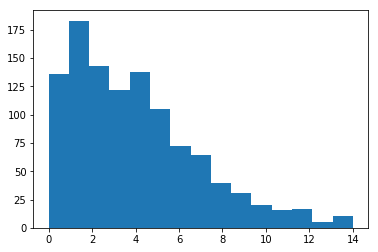

In [12]:
fig, ax = plt.subplots()
ax.hist((penultimate["away_score"] - penultimate["home_score"]).abs(), bins=15, )

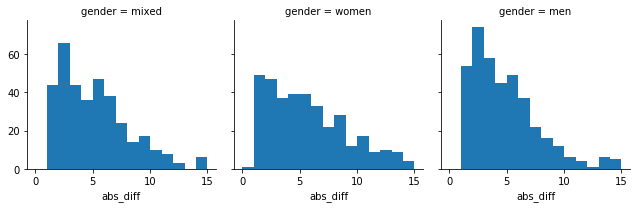

In [13]:
g = sns.FacetGrid(results, col="gender")
g.map(plt.hist, "abs_diff", bins=15, range=(0, 15))

In [14]:
# Checking some bad scores
# score_progressions[score_progressions["url"] == "/teams/events/match_report/?EventGameId=%2fUcjDT5HuHWYDP2F6uIbdm41Oa7C7rxzRne%2fir2Y6bw%3d"]

In [32]:
universe_set = penultimate.loc[penultimate["home_score"] == penultimate["away_score"]].index.values
universe_progressions = score_progressions.loc[score_progressions["url"].isin(universe_set)]

In [33]:
def delta_scores(df, half_score=8):
    diff = df.diff()[1:].astype(int)
    res = df[1:].copy()
    res[["is_home_point", "is_away_point"]] = diff
    res["is_break"] = (res["is_home_point"].diff() == 0)
    res["is_break"] = res["is_break"].apply(lambda x: "break" if x else "hold")
    if not res.empty:
        res["is_break"].iloc[0] = "start"
        home_half_idx = np.where(res["home_score"] == half_score)[0]
        away_half_idx = np.where(res["away_score"] == half_score)[0]
        half_idx = 2 * half_score + 1
        if home_half_idx.shape[0] > 0:
            half_idx = min(half_idx, home_half_idx[0])
        if away_half_idx.shape[0] > 0:
            half_idx = min(half_idx, away_half_idx[0])
        if half_idx < min(2 * half_score + 1, res.shape[0] - 1):
            same_start_half = (res["is_home_point"].iloc[0] ==
                               res["is_home_point"].iloc[half_idx + 1])
            res["is_break"].iloc[half_idx + 1] = "half_break" if same_start_half else "half"
    return res

In [34]:
universe_breakdown = universe_progressions.groupby("url")[["home_score", "away_score"]].apply(delta_scores)

In [36]:
universe_breakdown["is_break"].value_counts()

hold          2189
break         1010
start          136
half            86
half_break      49
Name: is_break, dtype: int64

In [38]:
universe_breakdown.groupby("url")["is_break"].nth(-1).value_counts()

hold     89
break    47
Name: is_break, dtype: int64

In [39]:
1010/2189, 47/89

(0.46139789858382824, 0.5280898876404494)